# License Plate Number Detection using YOLOv3 and PyTesseract

In [1]:
from IPython.display import Image
from matplotlib import pyplot as plt

import cv2
import numpy as np

import re
import pytesseract
# if you had this error ("tesseract is not installed or it's not in your PATH."), 
#      then uncomment the line below based on the tesseract.exe path on your system
pytesseract.pytesseract.tesseract_cmd = r'C:\Program Files\Tesseract-OCR\tesseract.exe'

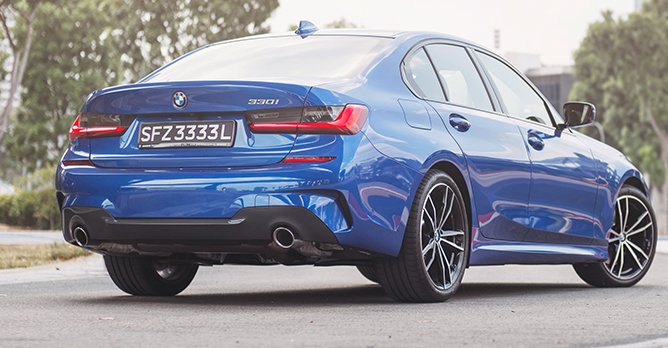

In [2]:
input_path = r'img1.jpg'
image = cv2.imread(input_path)
Image(input_path)

## YOLO Plate Detection Configuration

In [3]:
confThreshold = 0.5  #Confidence threshold
nmsThreshold = 0.4  #Non-maximum suppression threshold

inpWidth = 416     #Width of network's input image
inpHeight = 416     #Height of network's input image

In [4]:
# Load names of classes
classesFile = "classes.names";

classes = None
with open(classesFile, 'rt') as f:
    classes = f.read().rstrip('\n').split('\n')

### Use pretraind model "yolov3" for license plate detection

In [5]:
# Use pretraind model "yolov3" for license plate detection
modelConfiguration = r"darknet-yolov3.cfg";
modelWeights = r"lapi.weights";

In [6]:
net = cv2.dnn.readNetFromDarknet(modelConfiguration, modelWeights)
net.setPreferableBackend(cv2.dnn.DNN_BACKEND_OPENCV)
net.setPreferableTarget(cv2.dnn.DNN_TARGET_CPU)

### Extract bounding boxes with high confidence scores

In [7]:
def postprocess(image, outs):
    imgHeight = image.shape[0]
    imgWidth = image.shape[1]
    
    classIds = []
    confidences = []
    boxes = []
    for out in outs:
        for detection in out:
            scores = detection[5:]
            classId = np.argmax(scores)
            confidence = scores[classId]
            if confidence > confThreshold:
                center_x = int(detection[0] * imgWidth)
                center_y = int(detection[1] * imgHeight)
                width = int(detection[2] * imgWidth)
                height = int(detection[3] * imgHeight)
                left = int(center_x - width / 2)
                top = int(center_y - height / 2)
                classIds.append(classId)
                confidences.append(float(confidence))
                boxes.append([left, top, width, height])

    cropped=None
    # filtering out redundant or overlapping bounding boxes
    indices = cv2.dnn.NMSBoxes(boxes, confidences, confThreshold, nmsThreshold)
    for i in indices:
        box = boxes[i]
        left = box[0]
        top = box[1]
        width = box[2]
        height = box[3]
        
        # calculate bottom and right
        bottom = top + height
        right = left + width
        
        #crop the plate out
        cropped = image[top:bottom, left:right].copy()
        
        # Draw the predicted bounding box
        cv2.rectangle(image, (left, top), (right, bottom), (0, 255, 0), 3)

        #Display the label at the top of the bounding box
        label = ''
        labelSize, baseLine = cv2.getTextSize(label, cv2.FONT_HERSHEY_SIMPLEX, 0.5, 1)
        top = max(top, labelSize[1])
        cv2.rectangle(image, (left, top - round(1.5*labelSize[1])), (left + round(1.5*labelSize[0]), top + baseLine), (0, 0, 255), cv2.FILLED)
        cv2.putText(image, label, (left, top), cv2.FONT_HERSHEY_SIMPLEX, 0.75, (0,0,0), 2)
        
        
    if cropped is not None:
        return cropped

### Plate Detection

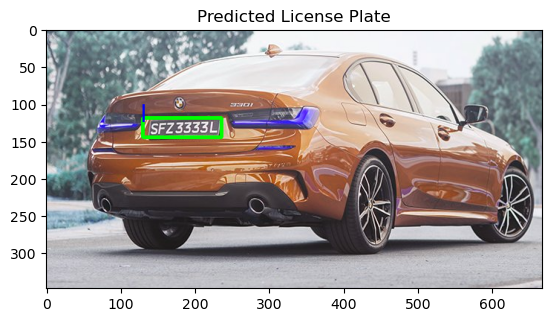

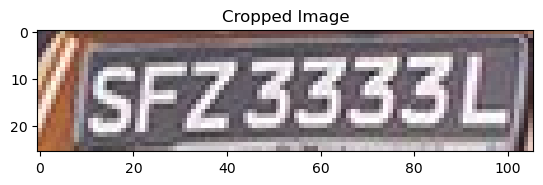

In [8]:
# Create a 4D blob from a frame
blob = cv2.dnn.blobFromImage(image, 1/255, (inpWidth, inpHeight), [0,0,0], 1, crop=False)

# Sets the input to the network
net.setInput(blob)

# Get output of the output layers
layer_names = net.getLayerNames()
output_layers = [layer_names[i - 1] for i in net.getUnconnectedOutLayers()] 
outs = net.forward(output_layers)

# Remove the bounding boxes with low confidence
cropped = postprocess(image, outs)

plt.imshow(image)
plt.title("Predicted License Plate")
plt.show()
plt.imshow(cropped)
plt.title("Cropped Image")
plt.show()

### License Number Detection

In [9]:
# Extract text from image
img_lp = cv2.resize(cropped, (333, 75))
img_gray_lp = cv2.cvtColor(img_lp, cv2.COLOR_BGR2GRAY)

extracted_text = pytesseract.image_to_string(img_gray_lp, lang='eng', config='--psm 7')

# Using a pattern to remove additional characters
pattern = r'[A-Za-z0-9]+'
plate_text = ' '.join(re.findall(pattern, extracted_text))

print("License Number:", plate_text)

License Number: SFZ3333L
